In [1]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
from shutil import copyfile
from glob import glob
import multiprocessing as mp
import matplotlib.pyplot as plt

# Monte Carlo Simulation for Damaged Networks

In [2]:
def get_bar_ranges(space):
    ranges = []
    for i in range(1,len(space)):
         ranges.append((space[i-1],space[i]))
    return ranges

def get_failure_groups(fail_probs,min_thre = 1e-3,num_groups = 10):
    valid_fails = [fail_prob for fail_prob in fail_probs if fail_prob > min_thre]
    count, space = np.histogram(valid_fails, num_groups)
    ranges = get_bar_ranges(space)
    return ranges
    

In [3]:
def get_failed_pipes_mask(pipe_info,groups):
    broken_pipes = np.zeros(len(pipe_info))
    for r in groups:
        pipes_mask = list((pipe_info['fail_prob'] > r[0]) & (pipe_info['fail_prob'] < r[1]))
        valid_indices = np.nonzero(pipes_mask)[0]
        num_fails = int(np.mean(r) * sum(pipes_mask))
        fail_indices = np.random.choice(valid_indices,num_fails,replace = False)
        broken_pipes[fail_indices] = 1
    return broken_pipes

In [4]:
def generate_leak_diameter(pipe_diam,min_ratio = 0.05, max_ratio = 0.25):
    r = np.random.uniform(min_ratio,max_ratio)
    return pipe_diam*r

In [5]:
def get_leak_sizes(pipe_info):
    leak_size = np.zeros(len(pipe_info))
    for index, row in pipe_info.iterrows():
        d,repair = row['diameter'],row['repair']
        if repair:
            leak_d = generate_leak_diameter(d)
            leak_size[index] = leak_d
    return leak_size

def fail_pipes_number(pipe_info):
    fail_probs = np.array(pipe_info['fail_prob'])
    groups = get_failure_groups(fail_probs)

    failed_pipes_mask = get_failed_pipes_mask(pipe_info,groups)
    num_failed_pipes = sum(failed_pipes_mask)
    print (f'number of failed pipes are : {num_failed_pipes}')
    return num_failed_pipes
    
def generate_random_leaks(pipe_info):
    fail_probs = np.array(pipe_info['fail_prob'])
    groups = get_failure_groups(fail_probs)

    failed_pipes_mask = get_failed_pipes_mask(pipe_info,groups)
#     print (f'number of failed pipes are : {sum(failed_pipes_mask)}')
    pipe_info['repair'] = failed_pipes_mask

    leak_sizes = get_leak_sizes(pipe_info)
    return leak_sizes

    

In [6]:
def write_leaks(file_path,df_leak_pipe): 
    with open(file_path, 'a') as the_file:
        for index, pipe in df_leak_pipe.iterrows():
            the_file.write(str(pipe['node1']) +'   ')
            the_file.write(str(pipe['leak_size']) +'   ')
            the_file.write('   ;\n')
        the_file.write('[END]\n')



In [7]:
def get_prefix(file_path):
    file_name = file_path.split('/')[-1]
    prefix = file_name.split('.')[0]
    return prefix[6:]

def mc_hydrausim(save_folder,pipe_info,mc_num):
    np.random.seed() 
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
        
    pipe_info['leak_size'] = generate_random_leaks(pipe_info)
    df_leak_pipe = pipe_info[pipe_info['repair'] == 1]
    
    # create .inp file with leak information 
    with open(TEMPLATE_PATH, 'r') as file:
        lines = file.readlines()
    lines[-1] = '[LEAKS]\n'
    lines.append(';ID   DIAMETER\n')

    name = f'im_sim_{mc_num}.inp'
    save_path = save_folder+ name 
    with open(save_path,'w') as fp:
        fp.writelines(lines)
    write_leaks(save_path,df_leak_pipe)
    # Use HydrauSim to Run Hydraulic Simulation
    command = '/home/rewu/Documents/research/pipe-network/build/pipe_network'
    # print (name[:-4])
    cmd = f'{command} -p -f {save_path} -t {save_folder} -n {name[:-4]} '
    os.system(cmd) 

def mp_hydrausim(save_folder,pipe_info):
    pool = mp.Pool(5)
    results = pool.starmap(mc_hydrausim, [(save_folder,pipe_info,i) for i in range(NUM_MC)])
    pool.close()

In [8]:
NUM_MC = 100 #100
TEMPLATE_PATH = '../data/processed_data/central/central.inp'
save_base_path = '../results/eq_results/'    

In [9]:
pipe_paths = glob('../data/rupture/pipes/*.geojson')
for pipe_path in pipe_paths[:1]:
    pipe_info = gpd.read_file(pipe_path)
    im = get_prefix(pipe_path)
    print (im)
#     print_fail_pipes(pipe_info)
    save_folder = save_base_path+im+'/'
    mp_hydrausim(save_folder,pipe_info)
    

im_rep47


# Postprocessing 


In [13]:
def get_low_pressure_nodes(node_tot):
    pressure_m = (node_tot['head']-(0.3048*node_tot['elevation']))
    # convert from m to psi 
    m_psi_const = 1.42197
    pressure_psi = pressure_m*m_psi_const
    node_tot['pressure'] = pressure_psi
    low_pressure_cond = node_tot['pressure']<33
    low_pressure_node = node_tot[low_pressure_cond]
    return low_pressure_node

def get_lack_demand_nodes(low_pressure_node):
    deficiency_ratio = get_deficiency_ratio(low_pressure_node)
    lack_demand_nodes = low_pressure_node[deficiency_ratio<0]
    return lack_demand_nodes

In [14]:
def get_deficiency_ratio(demand_nodes):
    deficiency = demand_nodes['MM_2018_gp']-demand_nodes['supply']
    deficiency_ratio = deficiency/demand_nodes['MM_2018_gp']*100
    return deficiency_ratio


In [15]:
def read_node_result(node_result_path):
    node_result = pd.read_csv(node_result_path)
    node_result = node_result.rename(columns={"node_name": "node_id","demand":"supply"})
    node_result['supply'] = node_result['supply']/6.30901964e-05 #unit conversion
    return node_result

def get_ave_defeciencies(demand_defeciencies,num_demand_nodes):
    deficiencies = np.zeros(num_demand_nodes)
    for demand_def in demand_defeciencies:
        deficiencies+=demand_def
    ave_def =  deficiencies/len(demand_defeciencies)
    return ave_def[:-3]

    
def analyze_realization(nodes_result_paths):
    demand_defeciencies= []
    for node_result_path in nodes_result_paths:
        node_result = read_node_result(node_result_path)

        node_tot = pd.merge(node_result, node_info, on='node_id', how='inner', indicator=False)
        demand_nodes = node_tot[node_tot['MM_2018_gp'] > 0]
        
        deficiency_ratio = get_deficiency_ratio(demand_nodes)
        demand_defeciencies.append(deficiency_ratio)

        low_pressure_node = get_low_pressure_nodes(node_tot)
        lack_demand_nodes = get_lack_demand_nodes(low_pressure_node)

#         print("num of low pressure nodes: ", len(low_pressure_node))
#     #     print("num of demand nodes: ", sum(node_info['MM_2018_gp']>0))
#         print("num of lack demand nodes: ", len(lack_demand_nodes))
    ave_def = get_ave_defeciencies(demand_defeciencies,len(demand_nodes))
    return ave_def
    
def show_result(demand_defeciencies,title):
    criteria = (demand_defeciencies>3) & (demand_defeciencies<100)
    qualified_def = demand_defeciencies[criteria]
    plt.hist(qualified_def, bins=[3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])  # arguments are passed to np.histogram
    plt.xlabel('Demand Deficiency Rate (%)')
    plt.ylabel('Number of Nodes')
    plt.title(title+f'; nnodes: {len(qualified_def)}')
    plt.show()
    

In [17]:
pz_name = 'central'
pz_folder = '../data/processed_data/%s/'%(pz_name)
node_info = gpd.read_file(pz_folder+'connected_nodes.geojson')
case_paths = glob(save_base_path+'/im_rep*')

In [18]:
case_names = []
ave_defs = []
for case_path in case_paths:
    print (case_path)
    nodes_result_paths = glob(case_path+'/im_sim_*_nodes.csv')
    case_name = case_path.split('/')[-1]
    demand_defeciencies = analyze_realization(nodes_result_paths)
    
    case_names.append(case_name) 
    ave_defs.append(demand_defeciencies)
    
#     show_result(demand_defeciencies,case_name)

../results/eq_results/im_rep47


In [19]:
def get_low_pressure_nodes(node_tot):
    pressure_m = (node_tot['head']-(0.3048*node_tot['elevation']))
    # convert from m to psi 
    m_psi_const = 1.42197
    pressure_psi = pressure_m*m_psi_const
    node_tot['pressure'] = pressure_psi
    low_pressure_cond = node_tot['pressure']<30
    low_pressure_node = node_tot[low_pressure_cond]
    return low_pressure_node

def get_lack_demand_nodes(low_pressure_node):
    deficiency_ratio = get_deficiency_ratio(low_pressure_node)
    lack_demand_nodes = low_pressure_node[deficiency_ratio>0]
    return lack_demand_nodes

In [21]:
import warnings
warnings.filterwarnings('ignore')

lack_pressure_ratios = []
lack_pressure_levels = []
for case_path in case_paths:
    nodes_result_paths = glob(case_path+'/im_sim_*_nodes.csv')
    case_name = case_path.split('/')[-1]
    
    ratios = []
    levels = []
    for p in nodes_result_paths:
        node_result = read_node_result(p)
        node_tot = pd.merge(node_result, node_info, on='node_id', how='inner', indicator=False)
        demand_nodes = node_tot[node_tot['MM_2018_gp'] > 0]
        low_pressure_node = get_low_pressure_nodes(demand_nodes)
        ratio = len(low_pressure_node)/len(demand_nodes)
        ratios.append(ratio)
        m = np.median(np.array(30-low_pressure_node['pressure']))
        levels.append(m)
    lack_pressure_ratios.append(np.mean(ratios)) 
    lack_pressure_levels.append(np.mean(levels))

In [22]:
pressure_m = (node_tot['head']-(0.3048*low_pressure_node['elevation']))
# convert from m to psi 
m_psi_const = 1.42197
pressure_psi = pressure_m*m_psi_const
low_pressure_node['pressure'] = pressure_psi

In [23]:
low_pressure_node

node_id       head    supply  leak_discharge   longitude   latitude  \
6086     36657  52.518841  0.074228               0 -122.346996  37.994277   
6344     37273  53.038475  0.370886               0 -122.345139  37.977602   
9416     44260  51.834331  1.445529               0 -122.160170  37.752132   
10230    45891  52.518839  0.173199               0 -122.347035  37.994152   
11746    48514  50.656332  2.187992               0 -122.173759  37.728464   
...        ...        ...       ...             ...         ...        ...   
59010   166168  50.287765  0.298409               0 -122.286899  37.889186   
59011   166169  50.287705  0.056273               0 -122.286101  37.889473   
59024   166794  52.575774  1.014596               0 -122.315654  37.913580   
59035   167324  50.288305  0.447222               0 -122.283344  37.875080   
60037   181526  50.288791  0.638282               0 -122.287226  37.887895   

       MM_2018_gp  elevation                     geometry   pressure  
6086     0.074228     104.36  POINT (-122.34700 37.99428)  29.448875  
6344     0.470113     133.17  POINT (-122.34514 37.97760)  17.701051  
9416     1.445529     103.23  POINT (-122.16017 37.75213)  28.965283  
10230    0.173199     104.37  POINT (-122.34704 37.99415)  29.444538  
11746    3.320228     137.70  POINT (-122.17376 37.72846)  12.350338  
...           ...        ...                          ...        ...  
59010    0.301575     100.74  POINT (-122.28690 37.88919)  27.845320  
59011    0.060315     107.87  POINT (-122.28610 37.88947)  24.754975  
59024    1.048322     111.03  POINT (-122.31565 37.91358)  26.638944  
59035    0.482520     108.62  POINT (-122.28334 37.87508)  24.430766  
60037    0.676633     106.60  POINT (-122.28723 37.88789)  25.306958  

[167 rows x 10 columns]

In [24]:
num_ld_nodes = []
for demand_defeciencies in ave_defs:
    criteria = (demand_defeciencies>0)
    qualified_def = demand_defeciencies[criteria]
    num_ld_nodes.append(len(qualified_def))

In [25]:
demand_node = np.array(node_info[node_info['MM_2018_gp']>0][:-3]['MM_2018_gp'])

num_ld_nodes = []
tot_water_shortage = []
for demand_defeciencies in ave_defs:
    criteria = (demand_defeciencies>5) & (demand_defeciencies<100)
    qualified_def = demand_defeciencies[criteria]
    num_ld_nodes.append(len(qualified_def))
    shortage_amount = sum(np.array(demand_defeciencies)*demand_node)
    tot_water_shortage.append(shortage_amount)
max(num_ld_nodes)

57

In [26]:
tot_demand = sum(node_info['MM_2018_gp'])
shortage_ratio = np.array(tot_water_shortage)/tot_demand

In [27]:
num_failed_pipes = []
for case_name in case_names:
    pipe_path = '/data/rupture/pipes/pipes_'+case_name+'.geojson'
    pipe_info = gpd.read_file(pipe_path)
    failed_pipes = fail_pipes_number(pipe_info)
    num_failed_pipes.append(failed_pipes)
print (min(num_failed_pipes),max(num_failed_pipes),np.mean(num_failed_pipes))

number of failed pipes are : 159.0
159.0 159.0 159.0


In [28]:
num_large_pgv_pipes1 = []
num_large_pgv_pipes2 = []

pgv_thre1 = 30
pgv_thre2 = 50

for case_name in case_names:
    pipe_path = '/data/rupture/pipes/pipes_'+case_name+'.geojson'
    pipe_info = gpd.read_file(pipe_path)
    num_large_move_pipes1 = len(pipe_info[pipe_info['pgv']>pgv_thre1])
    num_large_move_pipes2 = len(pipe_info[pipe_info['pgv']>pgv_thre2])

    num_large_pgv_pipes1.append(num_large_move_pipes1)
    num_large_pgv_pipes2.append(num_large_move_pipes2)
    

In [29]:
df_im = pd.read_csv('/data/rupture/result/im_analysis.csv')
r = np.array(num_ld_nodes)/len(demand_node)*100
lack_pressure_ratios = np.array(lack_pressure_ratios)*100
df_dict = {'Lack supply nodes ratio (%)' : r,
           'Lack of pressure nodes ratio (%)' : lack_pressure_ratios,
           'Mean pressure loss (PSI)' : lack_pressure_levels,
           'case_name' : case_names,
           'Pipe failure number': num_failed_pipes,
           'Number of large PGV pipes (30 cm/s)':num_large_pgv_pipes1,
           'Number of large PGV pipes (50 cm/s)':num_large_pgv_pipes2,
          'Shortage Ratio (%)': shortage_ratio}

df_leak = pd.DataFrame.from_dict(df_dict)
df_merge = pd.merge(df_im, df_leak, on='case_name', how='inner', indicator=False)

## Visualization

In [30]:
np.mean(lack_pressure_ratios)

0.5632947684420008

Text(0,0.5,'Number of Large PGV Value Pipes')

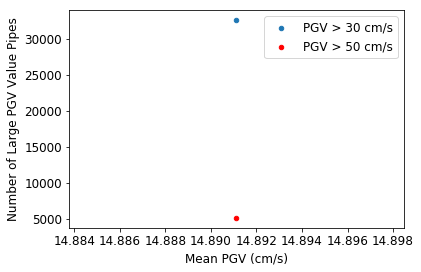

In [31]:
plt.rcParams.update({'font.size': 12})
ax0 = df_merge.plot(kind='scatter', x='Mean PGV (cm/s)', y='Number of large PGV pipes (30 cm/s)',
                   label="PGV > 30 cm/s")  
ax0 = df_merge.plot(kind='scatter', x='Mean PGV (cm/s)', y='Number of large PGV pipes (50 cm/s)',
                    color='r',ax=ax0,label="PGV > 50 cm/s")  
ax0.set_ylabel("Number of Large PGV Value Pipes")

# plt.savefig('../results/pgvonpipe.png',dpi=300, bbox_inches='tight')

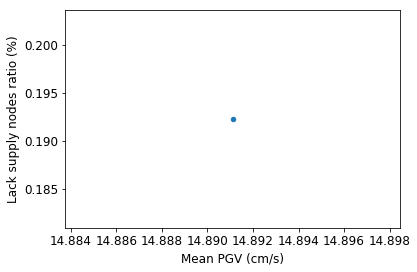

In [32]:
plt.rcParams.update({'font.size': 12})
ax1 = df_merge.plot.scatter(x='Mean PGV (cm/s)',
                      y='Lack supply nodes ratio (%)')
# plt.savefig('../results/pgv_nodes.png',dpi=300, bbox_inches='tight')

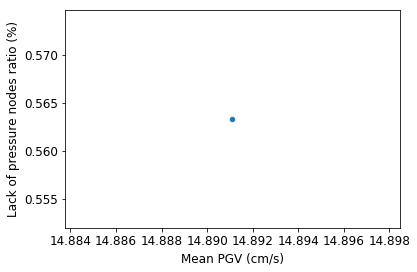

In [33]:
plt.rcParams.update({'font.size': 12})
ax1 = df_merge.plot.scatter(x='Mean PGV (cm/s)',
                      y='Lack of pressure nodes ratio (%)')
# plt.savefig('../results/pressure_ratio.png',dpi=300, bbox_inches='tight')

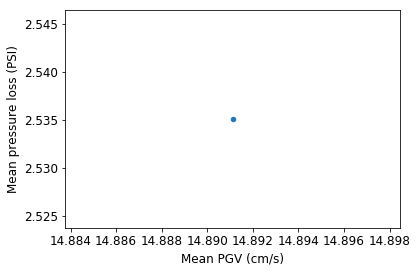

In [34]:
plt.rcParams.update({'font.size': 12})
ax1 = df_merge.plot.scatter(x='Mean PGV (cm/s)',
                      y='Mean pressure loss (PSI)')
# plt.savefig('../results/pressure_loss_level.png',dpi=300, bbox_inches='tight')

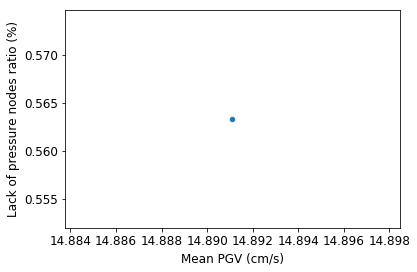

In [35]:
plt.rcParams.update({'font.size': 12})
ax1 = df_merge.plot.scatter(x='Mean PGV (cm/s)',
                      y='Lack of pressure nodes ratio (%)')


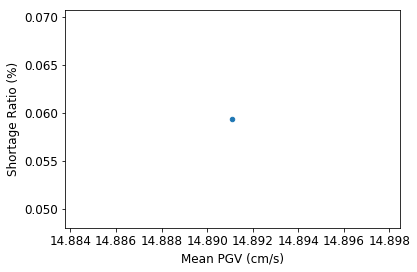

In [36]:
ax2 = df_merge.plot.scatter(x='Mean PGV (cm/s)',
                      y='Shortage Ratio (%)')
# plt.savefig('../results/pgv_ratio.png',dpi=300, bbox_inches='tight')

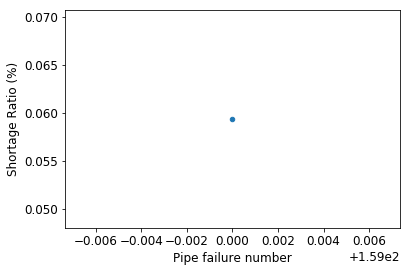

In [37]:
ax3 = df_merge.plot.scatter(x='Pipe failure number',
                      y='Shortage Ratio (%)')
# plt.savefig('../results/failed_pipe_shortage.png',dpi=300, bbox_inches='tight')

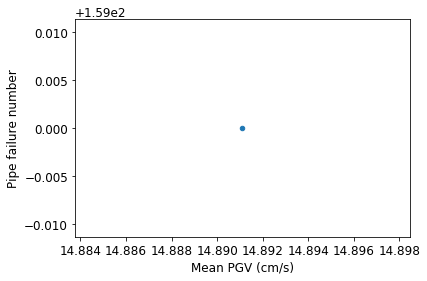

In [38]:
ax4 = df_merge.plot.scatter(x='Mean PGV (cm/s)',
                      y='Pipe failure number')
# plt.savefig('../results/pgv_pipes.png',dpi=300, bbox_inches='tight')

In [39]:
demand_nodes = node_info[node_info['MM_2018_gp']>0][:-3]

In [40]:
for deficiencies, case_name in zip(ave_defs,case_names):
    col_name = case_name+'_shrt_ratio'
    demand_nodes[col_name] = deficiencies
    
demand_nodes.head()

node_id   longitude   latitude  MM_2018_gp  elevation  \
6     28989 -122.231164  37.772601    0.126254      17.95   
8     28991 -122.230007  37.784708    0.580767      53.43   
13    29000 -122.300651  37.806628    4.281816      15.29   
20    29020 -122.363065  37.929458    0.368678      14.72   
25    29025 -122.299491  37.806373    0.240852      15.33   

                       geometry  im_rep47_shrt_ratio  
6   POINT (-122.23116 37.77260)        -2.453284e-08  
8   POINT (-122.23001 37.78471)        -1.608157e-08  
13  POINT (-122.30065 37.80663)        -2.569041e-08  
20  POINT (-122.36306 37.92946)        -2.771547e-08  
25  POINT (-122.29949 37.80637)        -2.577709e-08

In [179]:
# save_data_base_path = '../data/rupture/water_result/'

# output_filename = save_data_base_path+'supply_shrt_ratio.geojson'
# demand_nodes.to_file(output_filename, driver="GeoJSON")

In [ ]:
# demand_nodes['ave_deficiencies'] = deficiencies
# demand_nodes = demand_nodes[demand_nodes['ave_deficiencies'] < 100]
# demand_nodes = gpd.GeoDataFrame(demand_nodes)

In [ ]:
# lack_demand_nodes = demand_nodes[demand_nodes['ave_deficiencies'] > 5]
# len(lack_demand_nodes)

In [ ]:
# output_filename = save_data_base_path+'demand_nodes.geojson'
# demand_nodes.to_file(output_filename, driver="GeoJSON")

In [ ]:
# output_filename = save_data_base_path+'lack_demand_nodes.geojson'
# lack_demand_nodes.to_file(output_filename, driver="GeoJSON")

## Specific Earthquake Scenario

In [235]:
keep_cols = ['node_id','geometry','elevation','im_rep24_shrt_ratio']
demand_rep24 = demand_nodes[keep_cols]
shrt_rep24 = demand_rep24[demand_rep24['im_rep24_shrt_ratio'] > 3]
shrt_rep24 = gpd.GeoDataFrame(shrt_rep24)

output_filename = save_data_base_path+'supply_shrt_ratio_24.geojson'
shrt_rep24.to_file(output_filename, driver="GeoJSON")

In [237]:
keep_cols = ['node_id','geometry','elevation','im_rep34_shrt_ratio']
demand_rep34 = demand_nodes[keep_cols]
shrt_rep34 = demand_rep34[demand_rep34['im_rep34_shrt_ratio'] > 3]
shrt_rep34 = gpd.GeoDataFrame(shrt_rep34)

output_filename = save_data_base_path+'supply_shrt_ratio_34.geojson'
shrt_rep34.to_file(output_filename, driver="GeoJSON")

In [243]:
keep_cols = ['node_id','geometry','elevation','im_rep35_shrt_ratio']
demand_rep35 = demand_nodes[keep_cols]
shrt_rep35 = demand_rep35[demand_rep35['im_rep35_shrt_ratio'] > 3]
shrt_rep35 = gpd.GeoDataFrame(shrt_rep35)

output_filename = save_data_base_path+'supply_shrt_ratio_35.geojson'
shrt_rep35.to_file(output_filename, driver="GeoJSON")

In [320]:
ave_defs = np.array(ave_defs)
tot_mean = np.mean(ave_defs,axis=0)
tot_std = np.std(ave_defs,axis=0)

In [333]:
keep_cols = ['node_id','geometry']
overall_result =  demand_nodes[keep_cols]
overall_result['ave_shrt_mean'] = tot_mean
overall_result['ave_shrt_std'] = tot_std
overall_result['ave_shrt_std_relative'] = tot_std/tot_mean*100

overall_result = gpd.GeoDataFrame(overall_result)

output_filename = save_data_base_path+'overall_shrt.geojson'
overall_result.to_file(output_filename, driver="GeoJSON")


/home/rewu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rewu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/rewu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [330]:
sum(overall_result['ave_shrt_mean']<3)/len(overall_result)

0.6942382944272028